In [1]:
import numpy as np
import pandas as pd
import multiprocessing
import tensorflow as tf
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.style.use('ggplot')
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')
DATA_PATH = '../../DataLake/stMary'
kf = KFold(n_splits=5)

def generate_dataset(arg_pleths, arg_resps, fs=125, shift_factor=4):
    import copy
    dataset = []
    window_size = fs * 60 # 7500
    shift = int(window_size/shift_factor)
    samples_len = len(arg_pleths)

    cpy_resps = copy.deepcopy(arg_resps)
    cpy_pleths = copy.deepcopy(arg_pleths)

    for j in range(samples_len):
        rr = cpy_resps[j]; ppg = cpy_pleths[j]

        rr['offset'] = (rr['offset']-rr['offset'].min())/1000
        size_lim = int(fs * np.ceil(rr['offset'].max()))
        ppg = ppg[:size_lim]
        shift_n_times = int((len(ppg)-window_size)/shift)+1

        samp_rr = [len(rr.loc[ (rr['offset']>=0+(int(shift/fs)*i)) & ((rr['offset']<int(window_size/fs)+(int(shift/fs)*i))) ]) for i in range(shift_n_times)]
        samp_ppg = [ppg[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]

        for i in range(len(samp_ppg)):
            temp = []
            temp.append(samp_ppg[i])
            temp.append(samp_rr[i])
            dataset.append(temp)

    return dataset


def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.asarray(output_signal)


def preprocessing(targets=None):
    print('Extract PLETH/RESP')
    pleths = [pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values for sid in targets.id.unique()]
    resps = [pd.read_csv(f'{DATA_PATH}/{sid}/respirationTimeline.csv', header=None, names=['sid', 'offset']) for sid in targets.id.unique()]

    # Before filtering: Check NaN
    for pleth in pleths:
        if any(np.isnan(pleth)):
            print('check')

    # Before filtering: Convert type as np.int16
    pleths = list(map(lambda pleth: pleth.astype(np.float32), pleths))


    print('Init Preprocessing: Filtering')
    taps = signal.firwin(numtaps=2000, cutoff=[0.5, 8.0], window='hamming', pass_zero=False, fs=125)
    w, h = signal.freqz(taps)
    pool = multiprocessing.Pool(processes=40)
    filtered_pleths = pool.starmap(signal.filtfilt, [(taps, 1.0, pleth) for pleth in pleths])
    pool.close()
    pool.join()


    print('Init Preprocessing: Windowing')
    dataset = generate_dataset(filtered_pleths, resps, shift_factor=60)


    print('Init Preprocessing: Resampling')
    pool = multiprocessing.Pool(processes=40)
    result = pool.starmap(signal_resample, [(pleth[0], 125, 30) for pleth in dataset])
    pool.close()
    pool.join()

    new_patient = []
    for i in range(len(dataset)):
        temp = []
        temp.append(result[i])
        temp.append(dataset[i][1])
        new_patient.append(temp)

    return new_patient


def prepare_modeling(dataset=None, batchsize=None):
    print(f'Prepare modeling')
    pleths = []
    resps = []
    for ppg, rr in dataset:
        pleths.append(ppg.astype(np.float32))
        resps.append(rr)
    pleths = np.asarray(pleths)
    resps = np.asarray(resps)
    print(pleths.shape, resps.shape)

    scaler = MinMaxScaler()
    scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
    print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

    x, y = scaled_pleths[:], resps[:]

    return tf.data.Dataset.from_tensor_slices((x, y)).batch(batchsize)

2023-07-20 20:45:24.233689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-20 20:45:24.379666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 20:45:25.070119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
patients = subjects.loc[subjects['diagnosis']!='0']
train_patients = patients.sample(frac=1, random_state=42)


counter = 1
raw_dataset = {
    'train': [],
    'val': []
}
dataset = {
    'train': [],
    'val': []
}
for train_idx, val_idx in kf.split(train_patients):
    print(f'{counter}th K-fold')
    counter = counter + 1
    # 이렇게 하는 이유는 Train과 Validation을 완벽히 구별시키기 위함이다.
    X_train = preprocessing(train_patients.iloc[train_idx])
    X_val = preprocessing(train_patients.iloc[val_idx])
    print(f'Preprocessing finished: {len(X_train)} / {len(X_val)}')

    raw_dataset['train'].append(X_train)
    raw_dataset['val'].append(X_val)
    
    train_dataset = prepare_modeling(X_train, batchsize=256)
    val_dataset = prepare_modeling(X_val, batchsize=256)

    dataset['train'].append(train_dataset)
    dataset['val'].append(val_dataset)

1th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5180 / 1328
Prepare modeling
(5180, 1800) (5180,)
(5180, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1328, 1800) (1328,)


2023-07-20 20:51:30.820352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14353 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


(1328, 1800, 1) <class 'numpy.float32'>
2th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5214 / 1294
Prepare modeling
(5214, 1800) (5214,)
(5214, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1294, 1800) (1294,)
(1294, 1800, 1) <class 'numpy.float32'>
3th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5182 / 1326
Prepare modeling
(5182, 1800) (5182,)
(5182, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1326, 1800) (1326,)
(1326, 1800, 1) <class 'numpy.float32'>
4th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resa

In [3]:
dataset['val']

[<_BatchDataset element_spec=(TensorSpec(shape=(None, 1800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 1800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 1800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 1800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 1800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>]

In [4]:
X_val = []
for j in range(5):
    X_sub = []
    for i in range(len(raw_dataset['val'][j])):
        X_sub.append(raw_dataset['val'][j][i][0])
    
    X_val.append(np.array(X_sub))

In [5]:
y_val = []
for j in range(5):
    y_sub = []
    for i in range(len(raw_dataset['val'][j])):
        y_sub.append(raw_dataset['val'][j][i][1])
    
    y_val.append(np.array(y_sub))

In [6]:
X_val[1].shape, y_val[1].shape

((1294, 1800), (1294,))

In [7]:
models1 = [tf.keras.models.load_model(f'../models/230613-DilatedConv-stmary-KF{i}') for i in range(5)]
models2 = [tf.keras.models.load_model(f'../models/230619-Bian-stmary-KF{i}') for i in range(5)]

In [8]:
y_preds1 = [models1[i].predict(dataset['val'][i]) for i in range(5)]
y_preds2 = [models2[i].predict(dataset['val'][i]) for i in range(5)]

2023-07-20 21:16:58.334515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1328]
	 [[{{node Placeholder/_1}}]]
2023-07-20 21:16:59.927049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


6/6 [==============================] - 4s 77ms/step


2023-07-20 21:17:02.158270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1294]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 1s 81ms/step


2023-07-20 21:17:02.872849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1326]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 1s 83ms/step


2023-07-20 21:17:03.595327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1246]
	 [[{{node Placeholder/_1}}]]


5/5 [==============================] - 1s 138ms/step


2023-07-20 21:17:04.482951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1314]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 0s 29ms/step


In [9]:
from scipy import stats
corr = []
idx = 2

## Pearson correlation coefficient

In [10]:
print(stats.shapiro(y_preds[idx].reshape(-1)))
print(stats.shapiro(y_val[idx].reshape(-1)))

ShapiroResult(statistic=0.9359115958213806, pvalue=1.902220690437773e-23)
ShapiroResult(statistic=0.9303876757621765, pvalue=2.344423415620151e-24)


위 `Shapiro-test` 를 진행하여서 정규성을 검토한 결과 호흡수 데이터의 실측값과 예측값 두 집단은 모두 정규성을 충족하지 못하는 것을 알 수 있다.

이상의 데이터는 중환자 집단에 대해서 실험 전과 후의 결과에 대한 비교이므로 `Wilcoxon signed rank test`를 진행하고자 한다.

In [56]:
stats.wilcoxon(y_preds[idx].reshape(-1), y_val[idx].reshape(-1))

WilcoxonResult(statistic=345197.0, pvalue=1.11817681995068e-11)

위 Wilcoxon signed rank test의 결과를 보았을 때 p-value 값이 유의수준 0.05보다 작으므로 호흡수의 실제값과 모델의 예측값은 서로 다른 집단이라고 볼 수 있다.

이는 반박할 수 없는 사실이며 PPG의 분석 및 생체신호 예측을 위해서는 더욱 더 연구되어야 한다는 점을 시사한다.

In [57]:
r = stats.pearsonr(y_preds[idx].reshape(-1), y_val[idx].reshape(-1), alternative='two-sided')
r

PearsonRResult(statistic=0.9056775277596699, pvalue=0.0)

하지만 동시에 앞서 설명된 MAE ± STD 지표들은 PPG 기반의 딥러닝 모델을 이용한 호흡수 예측이 지속적으로 발전하고 있음을 나타낸다.

무엇보다 `Pearson correlation coefficient`를 이용해서 상관관계를 확인하였을 때는 해당 피어슨값이 0.9057 정도로 유의수준 양의 상관관계를 나타내는 1에 근사하다.

이를 통해 호흡수의 실제값과 모델의 예측값의 상관관계가 강력하게 존재한다는 것을 설명할 수 있다.

## Linear Regression Analysis

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
linearmodel = LinearRegression()
linearmodel.fit(y_val[idx].reshape(-1,1), y_preds[idx].reshape(-1,1))
print(linearmodel.coef_, linearmodel.intercept_)

[[0.73817772]] [3.91325582]


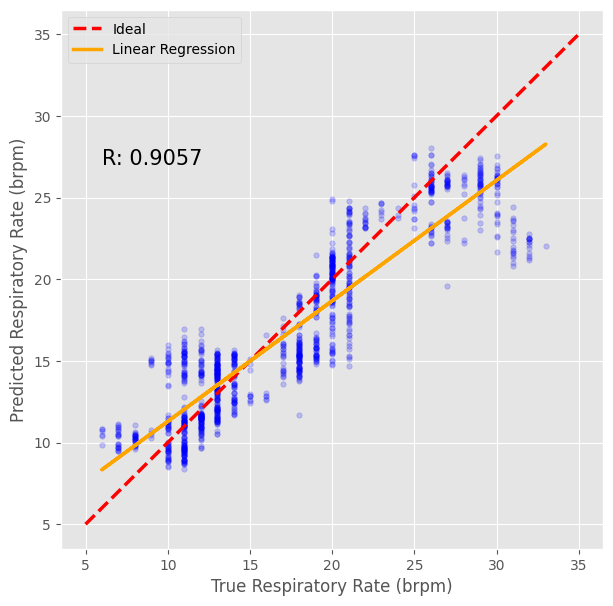

In [60]:
plt.figure(figsize=(7,7))
plt.scatter(y_val[idx], y_preds[idx], color='b', s=15, alpha=.2)
plt.plot([5, 35], [5, 35], color='red', linewidth=2.5, linestyle='--', label='Ideal')
plt.plot(y_val[idx], linearmodel.predict(y_val[idx].reshape(-1,1)), color='orange', linewidth=2.5, linestyle='-', label='Linear Regression')
plt.text(6,27, f'R: {r[0]:.4f}', fontsize=15)
plt.xlabel('True Respiratory Rate (brpm)')
plt.ylabel('Predicted Respiratory Rate (brpm)')
plt.legend()
plt.show()

실제 호흡수와 예측 호흡수의 상관관계를 비교 평가하기 위해 `Linear Regression plot`을 활용하였다.

위 plot에서 빨간 점선은 가장 이상적인 양의 상관관계를 나타내는 것이고 주황색 실선은 실제 호흡수와 예측 호흡수 사이의 측정된 상관관계를 나타낸다.

위 plot을 확인하였을 때 서울성모병원 SICU에서 취득한 데이터의 실제 호흡수와 예측 호흡수 사이에는 강력한 상관관계가 존재한다는 것을 확인할 수 있다.

## Error Distribution

In [61]:
measures = np.concatenate([y_val[idx].reshape(-1,1), y_preds[idx].reshape(-1,1)], axis=1)
diff = measures[:,0] - measures[:,1]
len(diff)

1326

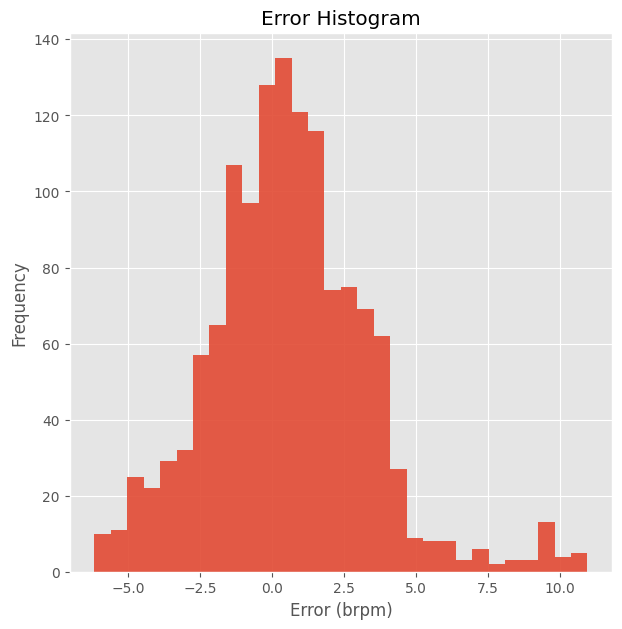

In [62]:
plt.figure(figsize=(7,7))
plt.title('Error Histogram')
plt.hist(diff, bins=30, histtype='stepfilled', alpha=.9)
plt.ylabel('Frequency')
plt.xlabel('Error (brpm)')
plt.show()

Error Histogram을 그려서 실제 호흡수와 예측 호흡수의 분산 정도를 시각화하였다. 

## Bland-Altman plot

In [10]:
measures = np.concatenate([y_val[idx].reshape(-1,1), y_preds2[idx].reshape(-1,1)], axis=1)
diff = measures[:,0] - measures[:,1]
avg = np.mean(measures, axis=1)
diff_avg = np.mean(diff)
diff_ci1 = diff_avg - 1.96 * np.std(diff)
diff_ci2 = diff_avg + 1.96 * np.std(diff)
print(diff_avg, diff_ci1, diff_ci2)

diff_lz1 = diff_avg - 1 * np.std(diff)
diff_rz1 = diff_avg + 1 * np.std(diff)
print(diff_lz1, diff_rz1)

diff_lz2 = diff_avg - 0.5 * np.std(diff)
diff_rz2 = diff_avg + 0.5 * np.std(diff)
print(diff_lz2, diff_rz2)

diff_lz3 = diff_avg - 0.3 * np.std(diff)
diff_rz3 = diff_avg + 0.3 * np.std(diff)
print(diff_lz3, diff_rz3)

diff_lz4 = diff_avg - 0.2 * np.std(diff)
diff_rz4 = diff_avg + 0.2 * np.std(diff)
print(diff_lz4, diff_rz4)

diff_lz5 = diff_avg - 0.1 * np.std(diff)
diff_rz5 = diff_avg + 0.1 * np.std(diff)
print(diff_lz5, diff_rz5)

outback1 = np.sum(diff > diff_ci2) + np.sum(diff < diff_ci1)
print((1 - outback1/len(diff))*100)

outback2 = np.sum(diff > diff_rz1) + np.sum(diff < diff_lz1)
print((1 - outback2/len(diff))*100)

rdiff = stats.pearsonr(avg, diff, alternative='two-sided')
print(rdiff)

0.15959842280564804 -5.775789825751508 6.094986671362804
-2.868660887682697 3.1878577332939932
-1.3545312324385246 1.6737280780498205
-0.7488793703408554 1.0680762159521515
-0.446053439292021 0.7652502849033171
-0.1432275082431865 0.46242435385448255
94.41930618401206
73.45399698340876
PearsonRResult(statistic=0.2993789935237824, pvalue=7.318172329875703e-29)


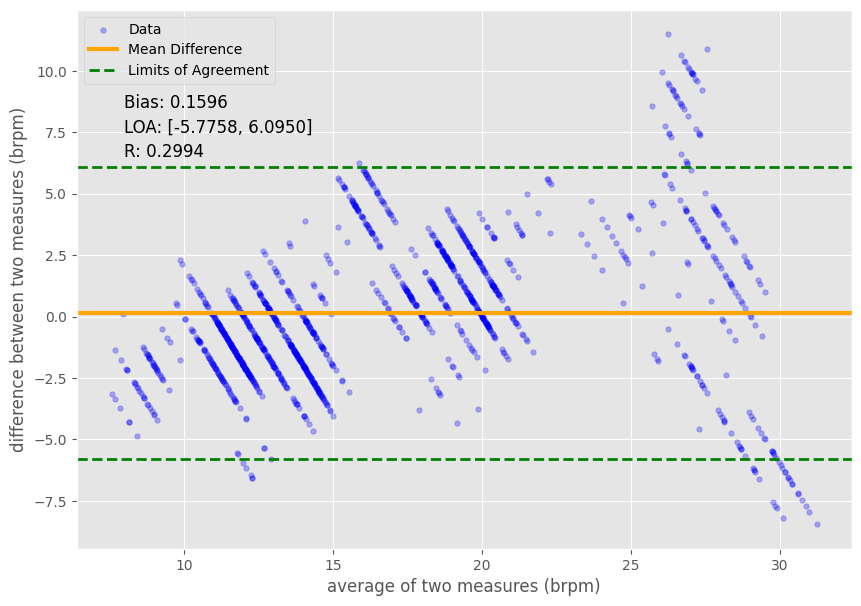

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(avg, diff, s=15, color='b', alpha=.3)
plt.axhline(diff_avg, linewidth=3, label='mean', c='orange')
plt.axhline(diff_ci1, linewidth=2, linestyle='--', c='green')
plt.axhline(diff_ci2, linewidth=2, linestyle='--', c='green')
# plt.axhline(diff_lz1, linewidth=2, linestyle=':', c='red')
# plt.axhline(diff_rz1, linewidth=2, linestyle=':', c='red')
plt.text(8,8.5,f'Bias: {diff_avg:.4f}', fontsize=12)
plt.text(8,7.5, f'LOA: [{diff_ci1:.4f}, {diff_ci2:.4f}]', fontsize=12)
plt.text(8,6.5, f'R: {rdiff[0]:.4f}', fontsize=12)
plt.xlabel('average of two measures (brpm)')
plt.ylabel('difference between two measures (brpm)')
plt.legend(['Data', 'Mean Difference', 'Limits of Agreement'])
plt.show()

Bland-Altman plot은 LOA를 세워서 두 정량적인 측정치들 간의 동의하는 정도를 수치적으로 표현하는 방법이다. 

이 방법은 수치 측정치들 간의 비교에 적절하며 새로운 기법이 Gold standard에 부합하는지 알아보는데 적합하다.

Bland-Altman plot 이 X축에 두 관측값의 평균을 사용하는 이유는 근본적으로 어느쪽이 참인지를 모르기 때문이다.

우리의 경우에는 참 값을 알고 있지만, 관례적으로 이와 같은 방법을 따라도 무방할 것으로 보인다.

Bland-Altman plot은 임의의 데이터에 대한 히스토그램을 위에서 내려다보는 느낌이라고 생각하면 좋다.

`Bland-Altman plot`을 확인하면 본 연구에서 활용된 모델 중 (MAE ± STD의 성과를 비교하였을 때) 제일 성과가 좋은 모델의 경우 위와 같은 결과를 보인다.

해당 플롯의 주황색선은 실제 호흡수와 예측 호흡수의 차이의 평균으로 0.5648 brpm 의 Bias를 갖고 있음을 볼 수 있다.

녹색점선으로 그려지는 95% 신뢰구간 (LOA, Limits Of Agreement)은 [-4.8109, 5.9401]로 94.27%의 결과값들이 LOA 안에 위치함을 확인할 수 있다.

더 나아가 노란색점선으로 z-score 1점인 구간은 [-2.1780 3.3072]로 72.55%의 결과값들이 해당 구간 안에 위치함을 확인할 수 있다.

이 평균을 중심으로 한 신뢰구간 안에 0이 있기 때문에 해당 결과는 편향성이 존재하지 않는다고 볼 수 있으며, 94.27%의 데이터가 실제와 예측 호흡수가 협의될 수 있는 LOA 안에 위치한 것을 확인할 수 있었다.

해석: https://igormintz.medium.com/the-bland-altman-plot-agreement-between-two-numerical-measurements-with-python-5504c38397c1

1. 만약 

2. 만약 평균차이의 신뢰구간이 0을 포함한다면, 편향성은 간과될 수 있다. 하지만 아니라면 높은 편향성이 존재한다는 것(그리고 그것이 중요할 수 있다는 것)을 나타낸다.

3. 두 측정치의 차이값이 무작위인지 트렌드를 보이는지를 확인할 수 있다.

## t-Test

실제값과 추정값 사이의 동등성 비교를 진행한다.

본 연구의 경우, 한 집단에 대해서 실험 전과 후를 비교하는 것으로 판단되며, 그 샘플이 1326 개로 중심극한정리를 충족하여 정규성을 만족한다고 본다.

그러므로 본 동등성 비교에서는 `Paired sample t-test`를 진행한다.

In [102]:
from scipy.stats import ttest_rel

In [103]:
test_res = ttest_rel(y_val[idx], y_preds[idx].reshape(-1))
test_res, test_res[1]

(TtestResult(statistic=7.49322782999601, pvalue=1.2234105092040457e-13, df=1325),
 1.2234105092040457e-13)

_Dilated ResNet_

이상의 결과에서 Dilated ResNet은 통계검정값: 7.4932, p-value: < 0.001 로 p-value가 0.05보다 작은 것을 확인할 수 있었다.

이는 실제 호흡수와 딥러닝 모델을 이용한 추정 호흡수 두 집단의 평균 사이에 차이가 존재하며, 둘을 서로 다른 집단으로 본다는 것이다.

_BianResNet_

이상의 결과에서 BianResNet은 통계검정값: 1.9184, p-value: 0.05527 로 p-value가 0.05보다 큰 것을 확인할 수 있었다.

이는 실제 호흡수와 딥러닝 모델을 이용한 추정 호흡수 두 집단 사이에 눈에 띄는 평균 차이가 존재하지 않으므로, 둘을 동등한 집단으로 볼 수 있다는 것이다.

이러한 결과를 시각적으로 확인해보기 위해 Histogram을 이용하여 나타내었다.

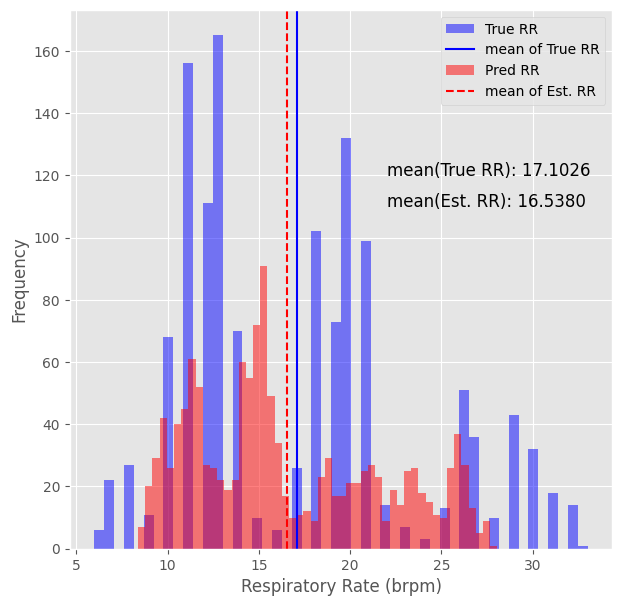

In [104]:
plt.figure(figsize=(7,7))
plt.hist(y_val[idx], bins=50, color='b', alpha=.5, label='True RR')
plt.axvline(np.mean(y_val[idx]), color='b', linestyle='-',label='mean of True RR')
plt.hist(y_preds[idx], bins=50, color='r', alpha=.5, label='Pred RR')
plt.axvline(np.mean(y_preds[idx]), color='r', linestyle='--', label='mean of Est. RR')
plt.text(22,120, f'mean(True RR): {np.mean(y_val[idx]):.4f}', fontsize=12)
plt.text(22,110, f'mean(Est. RR): {np.mean(y_preds[idx]):.4f}', fontsize=12)
plt.xlabel('Respiratory Rate (brpm)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

먼저 위 히스토그램에서 `True RR`의 결과가 이산적으로 나타나는 이유는 사람의 호흡수 자체가 실제로 이산적인 데이터이기 때문이다.

반면에 `Pred RR`의 경우 딥러닝 모델에 의한 연속적인 추정 결과값이 도출되기 때문에 위와 같은 양상을 보이게 된다.

주목할 부분은 `BianResNet` 모델의 추정 호흡수들의 평균이 실제 호흡수들의 평균과 매우 인접해 있다는 것이다.

이러한 점은 위에서 둘을 동등한 집단으로 판별하였던 t-test의 결과에 설득력을 더해준다.

## Bar plot

In [102]:
from scipy.stats import bartlett, ttest_ind

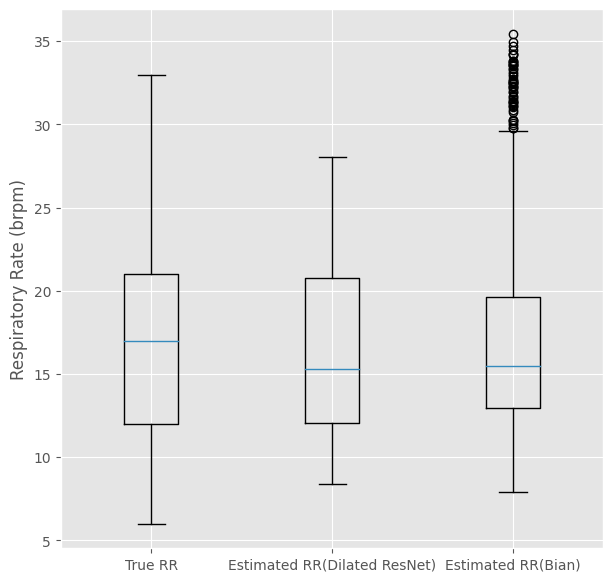

[array([12.,  6.]), array([21., 33.]), array([12.04133105,  8.38949203]), array([20.76211405, 28.06106377]), array([12.95461273,  7.89782   ]), array([19.60657024, 29.57979774])]


In [92]:
plt.figure(figsize=(7,7))
box = plt.boxplot([y_val[idx], y_preds1[idx].reshape(-1), y_preds2[idx].reshape(-1)], meanline=False)
plt.xticks([1,2,3], ['True RR', 'Estimated RR(Dilated ResNet)', 'Estimated RR(Bian)'])
# plt.xlabel('Data Type')
plt.ylabel('Respiratory Rate (brpm)')
plt.show()

whiskers = [item.get_ydata() for item in box['whiskers']]
medians = [item.get_ydata() for item in box['medians']]
fliers = [item.get_ydata() for item in box['fliers']]

print(whiskers) # [(첫번째 박스의 아래쪽 수염), (첫번째 박스의 위쪽 수염), (두번째), (두번째), (세번째), (세번째)]
# print(medians)
# print(fliers)

데이터의 전체적인 분포가 어떠하며, 각 데이터의 분포에서 이상치들은 어떤 양상을 보이는가.



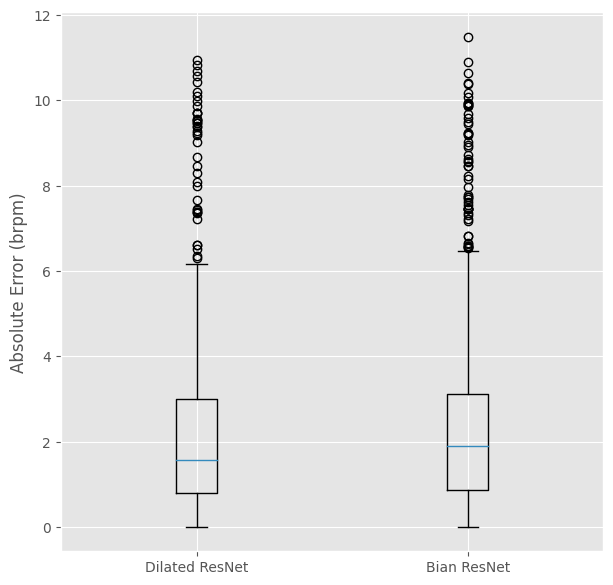

[array([0.78500819, 0.0018177 ]), array([2.98846412, 6.16109943]), array([0.86527467, 0.00192451]), array([3.11167955, 6.46611404])]
[array([1.57714367, 1.57714367]), array([1.89557838, 1.89557838])]
41 57


In [105]:
plt.figure(figsize=(7,7))
box_err = plt.boxplot([np.abs(y_val[idx]-y_preds1[idx].reshape(-1)), np.abs(y_val[idx]-y_preds2[idx].reshape(-1))])
plt.xticks([1,2], ['Dilated ResNet', 'Bian ResNet'])
# plt.xlabel('Data Type')
plt.ylabel('Absolute Error (brpm)')
plt.show()

whiskers = [item.get_ydata() for item in box_err['whiskers']]
medians = [item.get_ydata() for item in box_err['medians']]
fliers = [item.get_ydata() for item in box_err['fliers']]

print(whiskers)
print(medians)
print(len(fliers[0]), len(fliers[1]))

In [109]:
# Dilated ResNet의 추정 절대오차에서 IQR 사이에 위치하는 비율: 994/1326
len(np.where(np.abs(y_val[idx]-y_preds1[idx].reshape(-1)) <2.98846412)[0])

994

Figure는 성모병원 SICU로부터 입수한 PPG-RR을 이용하여 Dilated ResNet과 Bian ResNet을 학습 시킨 후 RR을 추정하였을 때, 실제 호흡수와 각각의 추정 호흡수 사이의 절대 오차를 나타낸 Box plot 이다.

이상의 결과에서, 두 모델은 절대 오차가 Q3를 넘어서는 Outlier가 1326개의 데이터 중 각각 41개(3.1%), 57개(4.3%) 인 것을 확인할 수 있었으며,

다만 위 두 모델을 비교하였을 때는 각각의 IQR을 보았을 때, 전체적으로 Dilated ResNet 모델이 Bian ResNet 모델보다 낮은 오차 경향을 보이는 것을 확인할 수 있었다.

두 모델의 오차 발생 수준은 유의미하게 다른가?

In [104]:
print(bartlett(y_val[idx]-y_preds1[idx].reshape(-1), y_val[idx]-y_preds2[idx].reshape(-1)))
print(ttest_ind(y_val[idx]-y_preds1[idx].reshape(-1), y_val[idx]-y_preds2[idx].reshape(-1), equal_var=False))

BartlettResult(statistic=12.982044600774074, pvalue=0.00031449235360579025)
Ttest_indResult(statistic=3.608135239110636, pvalue=0.0003141669076208519)


두 오차 집단이 등분산을 보이지 않는 것을 확인하였고 (BartlettResult(statistic=12.982044600774074, pvalue=0.00031449235360579025))

이때 Welch t-test를 시행한 결과, 각 모델로부터 추정한 호흡수의 오차 집단은 서로 유의미하게 다르다는 것을 확인할 수 있었다. (Ttest_indResult(statistic=3.608135239110636, pvalue=0.0003141669076208519))

이상의 결과를 통해 ResNet에 Dilated Convolution 등을 적용하여 공간 및 맥락적 정보를 다양하게 얻고자 한 시도가 유의미 하였음을 알 수 있었다.

## Classification Level

호흡수 예측 정확도를 확인하기 위해 이하와 같은 시도를 진행하였다.

- RR < 10
- 10 <= RR < 20
- 20 <= RR < 30
- RR >= 30 

In [40]:
y_preds[idx] = y_preds[idx].reshape(-1)

In [46]:
y_val[idx], np.round(y_preds[idx]).astype(np.int16)

(array([22, 21, 20, ..., 11, 11, 12]),
 array([23, 24, 23, ..., 10, 10, 10], dtype=int16))

In [42]:
print(len(np.where(y_val[idx]<10)[0]))
print(len(np.where((y_val[idx]>=10)&(y_val[idx]<20))[0]))
print(len(np.where((y_val[idx]>=20)&(y_val[idx]<30))[0]))
print(len(np.where(y_val[idx]>=30)[0]))

66
787
408
65


In [43]:
print(len(np.where(y_preds[idx]<10)[0]))
print(len(np.where((y_preds[idx]>=10)&(y_preds[idx]<20))[0]))
print(len(np.where((y_preds[idx]>=20)&(y_preds[idx]<30))[0]))
print(len(np.where(y_preds[idx]>=30)[0]))

99
853
374
0


In [53]:
clf_level = np.concatenate((y_val[idx].reshape(-1,1), np.round(y_preds[idx]).astype(np.int16).reshape(-1,1)), axis=1)
clf_level

array([[22, 23],
       [21, 24],
       [20, 23],
       ...,
       [11, 10],
       [11, 10],
       [12, 10]])

In [57]:
clf_level[np.where(clf_level[:, 0] < 10)[0]]

array([[ 8, 11],
       [ 7, 11],
       [ 7, 11],
       [ 7, 11],
       [ 7, 11],
       [ 7, 11],
       [ 6, 11],
       [ 6, 11],
       [ 6, 10],
       [ 6, 10],
       [ 6, 11],
       [ 7, 11],
       [ 7, 11],
       [ 7, 11],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 11],
       [ 8, 10],
       [ 9, 11],
       [ 9, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 11],
       [ 9, 10],
       [ 9, 11],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 8, 10],
       [ 7,  9],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 8, 10],
       [ 8, 10],
       [ 7,  9],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 6, 10],
       [ 7, 10